<a href="https://colab.research.google.com/github/wouffle/Image-colorization-using-GANs/blob/main/Image_colorization_using_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import files
import os

uploaded = files.upload()

# Create a directory to save the uploaded files
os.makedirs('dataset', exist_ok=True)

# Save the uploaded files to the created directory
for filename in uploaded.keys():
    with open(os.path.join('dataset', filename), 'wb') as f:
        f.write(uploaded[filename])


Saving Color image.jpg to Color image (1).jpg
Saving Grayscale image.jpg to Grayscale image (1).jpg


Color Image: Color image (1).jpg, Size: (256, 256, 3)
Grayscale Image: Color image (1).jpg, Size: (256, 256, 1)
Color Image: Grayscale image (1).jpg, Size: (256, 256, 3)
Grayscale Image: Grayscale image (1).jpg, Size: (256, 256, 1)
1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch: 0, D Loss: 0.7443560063838959, G Loss: 0.6453763246536255
1/1 [==============================] - 1s 743ms/step


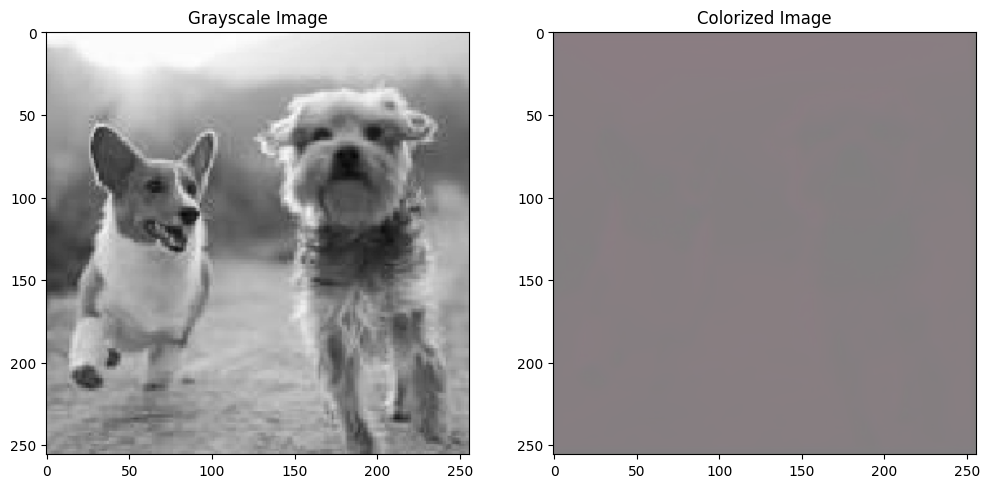

In [11]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, UpSampling2D, LeakyReLU, Concatenate
from keras.models import Model, Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define image size
image_size = 256

# Function to load images from directory
def load_images_from_directory(directory, image_size):
    gray_images = []
    color_images = []

    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Load the color image
            color_image = load_img(os.path.join(directory, filename), target_size=(image_size, image_size))
            color_image = img_to_array(color_image) / 255.0  # Normalize to [0, 1]
            color_images.append(color_image)

            # Print the size of the image
            print(f"Color Image: {filename}, Size: {color_image.shape}")

            # Convert to grayscale
            gray_image = load_img(os.path.join(directory, filename), color_mode='grayscale', target_size=(image_size, image_size))
            gray_image = img_to_array(gray_image) / 255.0  # Normalize to [0, 1]
            gray_images.append(gray_image)

            # Print the size of the grayscale image
            print(f"Grayscale Image: {filename}, Size: {gray_image.shape}")

    return np.array(gray_images), np.array(color_images)

# Load dataset
directory = 'dataset'  # Directory where images are uploaded
gray_images, color_images = load_images_from_directory(directory, image_size)

# Function to build the generator model
def build_generator(image_size):
    input_layer = Input(shape=(image_size, image_size, 1))

    # Encoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = UpSampling2D()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    output_layer = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(input_layer, output_layer)

# Function to build the discriminator model
def build_discriminator(image_size):
    input_layer = Input(shape=(image_size, image_size, 3))

    x = Conv2D(64, (3, 3), padding='same')(input_layer)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(256, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(512, (3, 3), strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)

    return Model(input_layer, x)

# Initialize the models
generator = build_generator(image_size)
discriminator = build_discriminator(image_size)

# Compile the discriminator
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Build and compile the GAN model
input_layer = Input(shape=(image_size, image_size, 1))
generated_image = generator(input_layer)
discriminator.trainable = False
validity = discriminator(generated_image)

gan_model = Model(input_layer, validity)
gan_model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')

# Training the GAN
epochs = 1  # Use a smaller number of epochs for testing
batch_size = 2  # Adjust batch size for RAM constraints

for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, gray_images.shape[0], batch_size)
    gray_batch = gray_images[idx]
    color_batch = color_images[idx]

    generated_images = generator.predict(gray_batch)

    d_loss_real = discriminator.train_on_batch(color_batch, np.ones((batch_size, 32, 32, 1)))
    d_loss_fake = discriminator.train_on_batch(generated_images, np.zeros((batch_size, 32, 32, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    g_loss = gan_model.train_on_batch(gray_batch, np.ones((batch_size, 32, 32, 1)))

    print(f"Epoch: {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")

# Save the generator model
generator.save('colorization_generator.h5')

# Example: Using the trained generator to colorize an image
example_gray_image = gray_images[0:1]  # Take the first image from the dataset
colorized_image = generator.predict(example_gray_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Grayscale Image")
plt.imshow(example_gray_image[0].reshape(image_size, image_size), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Colorized Image")
plt.imshow(colorized_image[0])
plt.show()
